# Importações e funções auxiliares

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygame
import seaborn as sns
import random
from collections import defaultdict

# our classes
from agent import Agent, QLearningAgent, MonteCarloAgent
from environment import Environment
from screen import Screen

# define environment
ACTION_SPACE = np.eye(3)
NUM_ACTIONS = 3
NUM_STATES = 2 ** 11

# Set options to activate or deactivate the game view, and its speed
pygame.font.init()

def plot_metrics(metrics, filepath=None):
    formatted_dict = {'episodes': [],
                      'metrics': [],
                      'results': []}

    n = len(metrics['episodes'])
    for i in range(n):
        episode = metrics['episodes'][i]
        score = metrics['scores'][i]
        reward = metrics['rewards'][i]

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('score')
        formatted_dict['results'].append(score)

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('reward')
        formatted_dict['results'].append(reward)

    df_metrics = pd.DataFrame(formatted_dict)
    sns.lineplot(data=df_metrics, x='episodes', y='results', hue='metrics')
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)


def decode_state(encoded_state):
    """
    Decode a binary representation of a state into its decimal base;
    
    encoded_state: an array of 0s and 1s representing a binary value
    
    return: decimal value
    """
    decoded = ''
    for s in encoded_state:
        decoded += str(s)

    return int(decoded, 2)


def decode_action(encoded_action):
    if isinstance(encoded_action, np.ndarray):
        return encoded_action.argmax()
    return encoded_action

def default_reward(env):
    """
    Return the reward.
    The reward is:
        -10 when Snake crashes.
        +10 when Snake eats food
        0 otherwise
    """
    reward = 0
    if env.game.crash:
        reward = -10
    elif env.player.eaten:
        reward = 10

    return reward

pygame 2.0.0 (SDL 2.0.12, python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Monte Carlo

In [4]:
def run_monte_carlo(agent: Agent, reward_function, episodes, display, speed, verbose=True):
    # setting random seed
    random.seed(42)
    np.random.seed(42)

    if display:
        pygame.init()

    env = Environment(440, 440, reward_function)
    screen = Screen(env)

    episode = 0
    metrics = {'episodes': [],
               'scores': [],
               'rewards': []}

    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    start = time.time()
    while episode < episodes:
        states_and_actions_visited = []

        if display:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()

            screen.display()

        state1, done = env.reset()
        state1 = decode_state(state1)
        action1 = agent.choose_action(state1)
        episode_reward = 0
        while not done:
            # Getting the next state, reward
            state2, reward, done = env.step(action1)
            state2 = decode_state(state2)
            # Choosing the next action
            action2 = agent.choose_action(state2)

            # Learning the Q-value
            #decoded_action1 = decode_action(action1)
            #decoded_action2 = decode_action(action2)
            #agent.update(state1, state2, reward, decoded_action1, decoded_action2)

            state1 = state2
            action1 = action2
            episode_reward += reward

            if display:
                screen.display()
                pygame.time.wait(speed)

            end = time.time()
            diff = end - start
            if diff > 600: # 10min
                break

        # Acabou o episódio, hora de aprender
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in states_and_actions_visited])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            first_occurence_idx = next(i for i,x in enumerate(states_and_actions_visited)
                                       if x[0] == state and x[1] == action)
            G = sum([x[2]*(agent.gamma**i) for i,x in enumerate(states_and_actions_visited[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            agent.Q[state, action] = returns_sum[sa_pair] / returns_count[sa_pair]

        # Incrementar episódios e ir guardando as nossas métricas
        episode += 1
        if verbose:
            print(f'Game {episode}      Score: {env.game.score}')

        mean_reward = episode_reward/episodes
        metrics['episodes'].append(episode)
        metrics['rewards'].append(mean_reward)
        metrics['scores'].append(env.game.score)

        end = time.time()
        diff = end - start
        if diff > 600: # 10min
            break


    return metrics


Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 2
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 1
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 0
Game 17      Score: 1
Game 18      Score: 0
Game 19      Score: 0
Game 20      Score: 0
Game 21      Score: 0
Game 22      Score: 0
Game 23      Score: 0
Game 24      Score: 0
Game 25      Score: 0
Game 26      Score: 0
Game 27      Score: 0
Game 28      Score: 0
Game 29      Score: 0
Game 30      Score: 0
Game 31      Score: 0
Game 32      Score: 0
Game 33      Score: 0
Game 34      Score: 0
Game 35      Score: 0
Game 36      Score: 0
Game 37      Score: 0
Game 38      Score: 0
Game 39      Score: 0
Game 40      Score: 0
Game 41      Score: 1
Game 42      Score: 0
Game 43      Score: 0
Game 44      Score: 0
Game 45      Score: 0
Game 46      Score:

Game 376      Score: 0
Game 377      Score: 0
Game 378      Score: 0
Game 379      Score: 0
Game 380      Score: 0
Game 381      Score: 0
Game 382      Score: 0
Game 383      Score: 0
Game 384      Score: 0
Game 385      Score: 0
Game 386      Score: 0
Game 387      Score: 0
Game 388      Score: 0
Game 389      Score: 0
Game 390      Score: 0
Game 391      Score: 0
Game 392      Score: 0
Game 393      Score: 0
Game 394      Score: 0
Game 395      Score: 0
Game 396      Score: 0
Game 397      Score: 0
Game 398      Score: 0
Game 399      Score: 0
Game 400      Score: 0
Game 401      Score: 0
Game 402      Score: 0
Game 403      Score: 0
Game 404      Score: 0
Game 405      Score: 0
Game 406      Score: 0
Game 407      Score: 0
Game 408      Score: 0
Game 409      Score: 0
Game 410      Score: 0
Game 411      Score: 0
Game 412      Score: 0
Game 413      Score: 0
Game 414      Score: 0
Game 415      Score: 0
Game 416      Score: 0
Game 417      Score: 0
Game 418      Score: 0
Game 419   

Game 744      Score: 0
Game 745      Score: 0
Game 746      Score: 0
Game 747      Score: 0
Game 748      Score: 0
Game 749      Score: 0
Game 750      Score: 0
Game 751      Score: 0
Game 752      Score: 0
Game 753      Score: 0
Game 754      Score: 0
Game 755      Score: 0
Game 756      Score: 0
Game 757      Score: 0
Game 758      Score: 0
Game 759      Score: 0
Game 760      Score: 0
Game 761      Score: 0
Game 762      Score: 0
Game 763      Score: 0
Game 764      Score: 0
Game 765      Score: 0
Game 766      Score: 0
Game 767      Score: 0
Game 768      Score: 0
Game 769      Score: 0
Game 770      Score: 0
Game 771      Score: 0
Game 772      Score: 0
Game 773      Score: 0
Game 774      Score: 0
Game 775      Score: 0
Game 776      Score: 0
Game 777      Score: 0
Game 778      Score: 0
Game 779      Score: 0
Game 780      Score: 0
Game 781      Score: 0
Game 782      Score: 0
Game 783      Score: 0
Game 784      Score: 0
Game 785      Score: 0
Game 786      Score: 0
Game 787   

Game 1110      Score: 0
Game 1111      Score: 0
Game 1112      Score: 0
Game 1113      Score: 0
Game 1114      Score: 0
Game 1115      Score: 0
Game 1116      Score: 0
Game 1117      Score: 0
Game 1118      Score: 0
Game 1119      Score: 0
Game 1120      Score: 0
Game 1121      Score: 0
Game 1122      Score: 0
Game 1123      Score: 0
Game 1124      Score: 0
Game 1125      Score: 0
Game 1126      Score: 0
Game 1127      Score: 0
Game 1128      Score: 0
Game 1129      Score: 0
Game 1130      Score: 0
Game 1131      Score: 0
Game 1132      Score: 0
Game 1133      Score: 0
Game 1134      Score: 0
Game 1135      Score: 0
Game 1136      Score: 0
Game 1137      Score: 0
Game 1138      Score: 0
Game 1139      Score: 0
Game 1140      Score: 0
Game 1141      Score: 0
Game 1142      Score: 0
Game 1143      Score: 0
Game 1144      Score: 0
Game 1145      Score: 0
Game 1146      Score: 0
Game 1147      Score: 0
Game 1148      Score: 0
Game 1149      Score: 0
Game 1150      Score: 0
Game 1151      S

Game 1474      Score: 0
Game 1475      Score: 0
Game 1476      Score: 0
Game 1477      Score: 0
Game 1478      Score: 0
Game 1479      Score: 0
Game 1480      Score: 0
Game 1481      Score: 0
Game 1482      Score: 0
Game 1483      Score: 0
Game 1484      Score: 0
Game 1485      Score: 0
Game 1486      Score: 0
Game 1487      Score: 0
Game 1488      Score: 0
Game 1489      Score: 0
Game 1490      Score: 0
Game 1491      Score: 0
Game 1492      Score: 0
Game 1493      Score: 0
Game 1494      Score: 0
Game 1495      Score: 0
Game 1496      Score: 0
Game 1497      Score: 0
Game 1498      Score: 0
Game 1499      Score: 0
Game 1500      Score: 0
Game 1501      Score: 0
Game 1502      Score: 0
Game 1503      Score: 0
Game 1504      Score: 0
Game 1505      Score: 0
Game 1506      Score: 0
Game 1507      Score: 0
Game 1508      Score: 0
Game 1509      Score: 0
Game 1510      Score: 0
Game 1511      Score: 0
Game 1512      Score: 0
Game 1513      Score: 0
Game 1514      Score: 0
Game 1515      S

Game 1826      Score: 0
Game 1827      Score: 0
Game 1828      Score: 0
Game 1829      Score: 0
Game 1830      Score: 0
Game 1831      Score: 0
Game 1832      Score: 0
Game 1833      Score: 0
Game 1834      Score: 0
Game 1835      Score: 0
Game 1836      Score: 0
Game 1837      Score: 0
Game 1838      Score: 0
Game 1839      Score: 0
Game 1840      Score: 0
Game 1841      Score: 0
Game 1842      Score: 0
Game 1843      Score: 0
Game 1844      Score: 0
Game 1845      Score: 0
Game 1846      Score: 0
Game 1847      Score: 0
Game 1848      Score: 0
Game 1849      Score: 0
Game 1850      Score: 0
Game 1851      Score: 0
Game 1852      Score: 0
Game 1853      Score: 0
Game 1854      Score: 0
Game 1855      Score: 0
Game 1856      Score: 0
Game 1857      Score: 0
Game 1858      Score: 0
Game 1859      Score: 0
Game 1860      Score: 0
Game 1861      Score: 0
Game 1862      Score: 0
Game 1863      Score: 0
Game 1864      Score: 0
Game 1865      Score: 0
Game 1866      Score: 0
Game 1867      S

Game 2182      Score: 0
Game 2183      Score: 0
Game 2184      Score: 0
Game 2185      Score: 0
Game 2186      Score: 0
Game 2187      Score: 0
Game 2188      Score: 0
Game 2189      Score: 0
Game 2190      Score: 0
Game 2191      Score: 0
Game 2192      Score: 0
Game 2193      Score: 0
Game 2194      Score: 0
Game 2195      Score: 0
Game 2196      Score: 0
Game 2197      Score: 0
Game 2198      Score: 0
Game 2199      Score: 0
Game 2200      Score: 0
Game 2201      Score: 0
Game 2202      Score: 0
Game 2203      Score: 0
Game 2204      Score: 0
Game 2205      Score: 0
Game 2206      Score: 0
Game 2207      Score: 0
Game 2208      Score: 0
Game 2209      Score: 0
Game 2210      Score: 0
Game 2211      Score: 0
Game 2212      Score: 0
Game 2213      Score: 0
Game 2214      Score: 0
Game 2215      Score: 0
Game 2216      Score: 0
Game 2217      Score: 0
Game 2218      Score: 0
Game 2219      Score: 0
Game 2220      Score: 0
Game 2221      Score: 0
Game 2222      Score: 0
Game 2223      S

Game 2550      Score: 0
Game 2551      Score: 0
Game 2552      Score: 0
Game 2553      Score: 0
Game 2554      Score: 0
Game 2555      Score: 0
Game 2556      Score: 0
Game 2557      Score: 0
Game 2558      Score: 0
Game 2559      Score: 0
Game 2560      Score: 0
Game 2561      Score: 0
Game 2562      Score: 0
Game 2563      Score: 0
Game 2564      Score: 0
Game 2565      Score: 0
Game 2566      Score: 0
Game 2567      Score: 0
Game 2568      Score: 0
Game 2569      Score: 0
Game 2570      Score: 0
Game 2571      Score: 0
Game 2572      Score: 0
Game 2573      Score: 0
Game 2574      Score: 0
Game 2575      Score: 0
Game 2576      Score: 0
Game 2577      Score: 0
Game 2578      Score: 0
Game 2579      Score: 0
Game 2580      Score: 0
Game 2581      Score: 0
Game 2582      Score: 0
Game 2583      Score: 0
Game 2584      Score: 0
Game 2585      Score: 0
Game 2586      Score: 0
Game 2587      Score: 0
Game 2588      Score: 0
Game 2589      Score: 0
Game 2590      Score: 0
Game 2591      S

Game 2898      Score: 0
Game 2899      Score: 0
Game 2900      Score: 0
Game 2901      Score: 0
Game 2902      Score: 0
Game 2903      Score: 0
Game 2904      Score: 0
Game 2905      Score: 0
Game 2906      Score: 0
Game 2907      Score: 0
Game 2908      Score: 0
Game 2909      Score: 0
Game 2910      Score: 0
Game 2911      Score: 0
Game 2912      Score: 0
Game 2913      Score: 0
Game 2914      Score: 0
Game 2915      Score: 0
Game 2916      Score: 0
Game 2917      Score: 0
Game 2918      Score: 0
Game 2919      Score: 0
Game 2920      Score: 0
Game 2921      Score: 0
Game 2922      Score: 0
Game 2923      Score: 0
Game 2924      Score: 0
Game 2925      Score: 0
Game 2926      Score: 0
Game 2927      Score: 0
Game 2928      Score: 0
Game 2929      Score: 0
Game 2930      Score: 0
Game 2931      Score: 0
Game 2932      Score: 0
Game 2933      Score: 0
Game 2934      Score: 0
Game 2935      Score: 0
Game 2936      Score: 0
Game 2937      Score: 0
Game 2938      Score: 0
Game 2939      S

Game 3250      Score: 0
Game 3251      Score: 0
Game 3252      Score: 0
Game 3253      Score: 0
Game 3254      Score: 0
Game 3255      Score: 0
Game 3256      Score: 0
Game 3257      Score: 0
Game 3258      Score: 0
Game 3259      Score: 0
Game 3260      Score: 0
Game 3261      Score: 0
Game 3262      Score: 0
Game 3263      Score: 0
Game 3264      Score: 0
Game 3265      Score: 0
Game 3266      Score: 0
Game 3267      Score: 0
Game 3268      Score: 0
Game 3269      Score: 0
Game 3270      Score: 0
Game 3271      Score: 0
Game 3272      Score: 0
Game 3273      Score: 0
Game 3274      Score: 0
Game 3275      Score: 0
Game 3276      Score: 0
Game 3277      Score: 0
Game 3278      Score: 0
Game 3279      Score: 0
Game 3280      Score: 0
Game 3281      Score: 0
Game 3282      Score: 0
Game 3283      Score: 0
Game 3284      Score: 0
Game 3285      Score: 0
Game 3286      Score: 0
Game 3287      Score: 0
Game 3288      Score: 0
Game 3289      Score: 0
Game 3290      Score: 0
Game 3291      S

Game 3595      Score: 0
Game 3596      Score: 0
Game 3597      Score: 0
Game 3598      Score: 0
Game 3599      Score: 0
Game 3600      Score: 0
Game 3601      Score: 0
Game 3602      Score: 0
Game 3603      Score: 0
Game 3604      Score: 0
Game 3605      Score: 0
Game 3606      Score: 0
Game 3607      Score: 0
Game 3608      Score: 0
Game 3609      Score: 0
Game 3610      Score: 0
Game 3611      Score: 0
Game 3612      Score: 0
Game 3613      Score: 0
Game 3614      Score: 0
Game 3615      Score: 0
Game 3616      Score: 0
Game 3617      Score: 0
Game 3618      Score: 0
Game 3619      Score: 0
Game 3620      Score: 0
Game 3621      Score: 0
Game 3622      Score: 0
Game 3623      Score: 0
Game 3624      Score: 0
Game 3625      Score: 0
Game 3626      Score: 0
Game 3627      Score: 0
Game 3628      Score: 0
Game 3629      Score: 0
Game 3630      Score: 0
Game 3631      Score: 0
Game 3632      Score: 0
Game 3633      Score: 0
Game 3634      Score: 0
Game 3635      Score: 0
Game 3636      S

Game 3957      Score: 0
Game 3958      Score: 0
Game 3959      Score: 0
Game 3960      Score: 0
Game 3961      Score: 0
Game 3962      Score: 0
Game 3963      Score: 0
Game 3964      Score: 0
Game 3965      Score: 0
Game 3966      Score: 0
Game 3967      Score: 0
Game 3968      Score: 0
Game 3969      Score: 0
Game 3970      Score: 0
Game 3971      Score: 0
Game 3972      Score: 0
Game 3973      Score: 0
Game 3974      Score: 0
Game 3975      Score: 0
Game 3976      Score: 0
Game 3977      Score: 0
Game 3978      Score: 0
Game 3979      Score: 0
Game 3980      Score: 0
Game 3981      Score: 0
Game 3982      Score: 0
Game 3983      Score: 0
Game 3984      Score: 0
Game 3985      Score: 0
Game 3986      Score: 0
Game 3987      Score: 0
Game 3988      Score: 0
Game 3989      Score: 0
Game 3990      Score: 0
Game 3991      Score: 0
Game 3992      Score: 0
Game 3993      Score: 0
Game 3994      Score: 0
Game 3995      Score: 0
Game 3996      Score: 0
Game 3997      Score: 0
Game 3998      S

Game 4306      Score: 0
Game 4307      Score: 0
Game 4308      Score: 0
Game 4309      Score: 0
Game 4310      Score: 0
Game 4311      Score: 0
Game 4312      Score: 0
Game 4313      Score: 0
Game 4314      Score: 0
Game 4315      Score: 0
Game 4316      Score: 0
Game 4317      Score: 0
Game 4318      Score: 0
Game 4319      Score: 0
Game 4320      Score: 0
Game 4321      Score: 0
Game 4322      Score: 0
Game 4323      Score: 0
Game 4324      Score: 0
Game 4325      Score: 0
Game 4326      Score: 0
Game 4327      Score: 0
Game 4328      Score: 0
Game 4329      Score: 0
Game 4330      Score: 0
Game 4331      Score: 0
Game 4332      Score: 0
Game 4333      Score: 0
Game 4334      Score: 0
Game 4335      Score: 0
Game 4336      Score: 0
Game 4337      Score: 0
Game 4338      Score: 0
Game 4339      Score: 0
Game 4340      Score: 0
Game 4341      Score: 0
Game 4342      Score: 0
Game 4343      Score: 0
Game 4344      Score: 0
Game 4345      Score: 0
Game 4346      Score: 0
Game 4347      S

Game 4676      Score: 0
Game 4677      Score: 0
Game 4678      Score: 0
Game 4679      Score: 0
Game 4680      Score: 0
Game 4681      Score: 0
Game 4682      Score: 0
Game 4683      Score: 0
Game 4684      Score: 0
Game 4685      Score: 0
Game 4686      Score: 0
Game 4687      Score: 0
Game 4688      Score: 0
Game 4689      Score: 0
Game 4690      Score: 0
Game 4691      Score: 0
Game 4692      Score: 0
Game 4693      Score: 0
Game 4694      Score: 0
Game 4695      Score: 0
Game 4696      Score: 0
Game 4697      Score: 0
Game 4698      Score: 0
Game 4699      Score: 0
Game 4700      Score: 0
Game 4701      Score: 0
Game 4702      Score: 0
Game 4703      Score: 0
Game 4704      Score: 0
Game 4705      Score: 0
Game 4706      Score: 0
Game 4707      Score: 0
Game 4708      Score: 0
Game 4709      Score: 0
Game 4710      Score: 0
Game 4711      Score: 0
Game 4712      Score: 0
Game 4713      Score: 0
Game 4714      Score: 0
Game 4715      Score: 0
Game 4716      Score: 0
Game 4717      S

Game 5018      Score: 0
Game 5019      Score: 0
Game 5020      Score: 0
Game 5021      Score: 0
Game 5022      Score: 0
Game 5023      Score: 0
Game 5024      Score: 0
Game 5025      Score: 0
Game 5026      Score: 0
Game 5027      Score: 0
Game 5028      Score: 0
Game 5029      Score: 0
Game 5030      Score: 0
Game 5031      Score: 0
Game 5032      Score: 0
Game 5033      Score: 0
Game 5034      Score: 0
Game 5035      Score: 0
Game 5036      Score: 0
Game 5037      Score: 0
Game 5038      Score: 0
Game 5039      Score: 0
Game 5040      Score: 0
Game 5041      Score: 0
Game 5042      Score: 0
Game 5043      Score: 0
Game 5044      Score: 0
Game 5045      Score: 0
Game 5046      Score: 0
Game 5047      Score: 0
Game 5048      Score: 0
Game 5049      Score: 0
Game 5050      Score: 0
Game 5051      Score: 0
Game 5052      Score: 0
Game 5053      Score: 0
Game 5054      Score: 0
Game 5055      Score: 0
Game 5056      Score: 0
Game 5057      Score: 0
Game 5058      Score: 0
Game 5059      S

Game 5369      Score: 0
Game 5370      Score: 0
Game 5371      Score: 0
Game 5372      Score: 0
Game 5373      Score: 0
Game 5374      Score: 0
Game 5375      Score: 0
Game 5376      Score: 0
Game 5377      Score: 0
Game 5378      Score: 0
Game 5379      Score: 0
Game 5380      Score: 0
Game 5381      Score: 0
Game 5382      Score: 0
Game 5383      Score: 0
Game 5384      Score: 0
Game 5385      Score: 0
Game 5386      Score: 0
Game 5387      Score: 0
Game 5388      Score: 0
Game 5389      Score: 0
Game 5390      Score: 0
Game 5391      Score: 0
Game 5392      Score: 0
Game 5393      Score: 0
Game 5394      Score: 0
Game 5395      Score: 0
Game 5396      Score: 0
Game 5397      Score: 0
Game 5398      Score: 0
Game 5399      Score: 0
Game 5400      Score: 0
Game 5401      Score: 0
Game 5402      Score: 0
Game 5403      Score: 0
Game 5404      Score: 0
Game 5405      Score: 0
Game 5406      Score: 0
Game 5407      Score: 0
Game 5408      Score: 0
Game 5409      Score: 0
Game 5410      S

Game 5716      Score: 0
Game 5717      Score: 0
Game 5718      Score: 0
Game 5719      Score: 0
Game 5720      Score: 0
Game 5721      Score: 0
Game 5722      Score: 0
Game 5723      Score: 0
Game 5724      Score: 0
Game 5725      Score: 0
Game 5726      Score: 0
Game 5727      Score: 0
Game 5728      Score: 0
Game 5729      Score: 0
Game 5730      Score: 0
Game 5731      Score: 0
Game 5732      Score: 0
Game 5733      Score: 0
Game 5734      Score: 0
Game 5735      Score: 0
Game 5736      Score: 0
Game 5737      Score: 0
Game 5738      Score: 0
Game 5739      Score: 0
Game 5740      Score: 0
Game 5741      Score: 0
Game 5742      Score: 0
Game 5743      Score: 0
Game 5744      Score: 0
Game 5745      Score: 0
Game 5746      Score: 0
Game 5747      Score: 0
Game 5748      Score: 0
Game 5749      Score: 0
Game 5750      Score: 0
Game 5751      Score: 0
Game 5752      Score: 0
Game 5753      Score: 0
Game 5754      Score: 0
Game 5755      Score: 0
Game 5756      Score: 0
Game 5757      S

Game 6066      Score: 0
Game 6067      Score: 0
Game 6068      Score: 0
Game 6069      Score: 0
Game 6070      Score: 0
Game 6071      Score: 0
Game 6072      Score: 0
Game 6073      Score: 0
Game 6074      Score: 0
Game 6075      Score: 0
Game 6076      Score: 0
Game 6077      Score: 0
Game 6078      Score: 0
Game 6079      Score: 0
Game 6080      Score: 0
Game 6081      Score: 0
Game 6082      Score: 0
Game 6083      Score: 0
Game 6084      Score: 0
Game 6085      Score: 0
Game 6086      Score: 0
Game 6087      Score: 0
Game 6088      Score: 0
Game 6089      Score: 0
Game 6090      Score: 0
Game 6091      Score: 0
Game 6092      Score: 0
Game 6093      Score: 0
Game 6094      Score: 0
Game 6095      Score: 0
Game 6096      Score: 0
Game 6097      Score: 0
Game 6098      Score: 0
Game 6099      Score: 0
Game 6100      Score: 0
Game 6101      Score: 0
Game 6102      Score: 0
Game 6103      Score: 0
Game 6104      Score: 0
Game 6105      Score: 0
Game 6106      Score: 0
Game 6107      S

Game 6417      Score: 0
Game 6418      Score: 0
Game 6419      Score: 0
Game 6420      Score: 0
Game 6421      Score: 0
Game 6422      Score: 0
Game 6423      Score: 0
Game 6424      Score: 0
Game 6425      Score: 0
Game 6426      Score: 0
Game 6427      Score: 0
Game 6428      Score: 0
Game 6429      Score: 0
Game 6430      Score: 0
Game 6431      Score: 0
Game 6432      Score: 0
Game 6433      Score: 0
Game 6434      Score: 0
Game 6435      Score: 0
Game 6436      Score: 0
Game 6437      Score: 0
Game 6438      Score: 0
Game 6439      Score: 0
Game 6440      Score: 0
Game 6441      Score: 0
Game 6442      Score: 0
Game 6443      Score: 0
Game 6444      Score: 0
Game 6445      Score: 0
Game 6446      Score: 0
Game 6447      Score: 0
Game 6448      Score: 0
Game 6449      Score: 0
Game 6450      Score: 0
Game 6451      Score: 0
Game 6452      Score: 0
Game 6453      Score: 0
Game 6454      Score: 0
Game 6455      Score: 0
Game 6456      Score: 0
Game 6457      Score: 0
Game 6458      S

Game 6764      Score: 0
Game 6765      Score: 0
Game 6766      Score: 0
Game 6767      Score: 0
Game 6768      Score: 0
Game 6769      Score: 0
Game 6770      Score: 0
Game 6771      Score: 0
Game 6772      Score: 0
Game 6773      Score: 0
Game 6774      Score: 0
Game 6775      Score: 0
Game 6776      Score: 0
Game 6777      Score: 0
Game 6778      Score: 0
Game 6779      Score: 0
Game 6780      Score: 0
Game 6781      Score: 0
Game 6782      Score: 0
Game 6783      Score: 0
Game 6784      Score: 0
Game 6785      Score: 0
Game 6786      Score: 0
Game 6787      Score: 0
Game 6788      Score: 0
Game 6789      Score: 0
Game 6790      Score: 0
Game 6791      Score: 0
Game 6792      Score: 0
Game 6793      Score: 0
Game 6794      Score: 0
Game 6795      Score: 0
Game 6796      Score: 0
Game 6797      Score: 0
Game 6798      Score: 0
Game 6799      Score: 0
Game 6800      Score: 0
Game 6801      Score: 0
Game 6802      Score: 0
Game 6803      Score: 0
Game 6804      Score: 0
Game 6805      S

Game 7114      Score: 0
Game 7115      Score: 0
Game 7116      Score: 0
Game 7117      Score: 0
Game 7118      Score: 0
Game 7119      Score: 0
Game 7120      Score: 0
Game 7121      Score: 0
Game 7122      Score: 0
Game 7123      Score: 0
Game 7124      Score: 0
Game 7125      Score: 0
Game 7126      Score: 0
Game 7127      Score: 0
Game 7128      Score: 0
Game 7129      Score: 0
Game 7130      Score: 0
Game 7131      Score: 0
Game 7132      Score: 0
Game 7133      Score: 0
Game 7134      Score: 0
Game 7135      Score: 0
Game 7136      Score: 0
Game 7137      Score: 0
Game 7138      Score: 0
Game 7139      Score: 0
Game 7140      Score: 0
Game 7141      Score: 0
Game 7142      Score: 0
Game 7143      Score: 0
Game 7144      Score: 0
Game 7145      Score: 0
Game 7146      Score: 0
Game 7147      Score: 0
Game 7148      Score: 0
Game 7149      Score: 0
Game 7150      Score: 0
Game 7151      Score: 0
Game 7152      Score: 0
Game 7153      Score: 0
Game 7154      Score: 0
Game 7155      S

Game 7466      Score: 0
Game 7467      Score: 0
Game 7468      Score: 0
Game 7469      Score: 0
Game 7470      Score: 0
Game 7471      Score: 0
Game 7472      Score: 0
Game 7473      Score: 0
Game 7474      Score: 0
Game 7475      Score: 0
Game 7476      Score: 0
Game 7477      Score: 0
Game 7478      Score: 0
Game 7479      Score: 0
Game 7480      Score: 0
Game 7481      Score: 0
Game 7482      Score: 0
Game 7483      Score: 0
Game 7484      Score: 0
Game 7485      Score: 0
Game 7486      Score: 0
Game 7487      Score: 0
Game 7488      Score: 0
Game 7489      Score: 0
Game 7490      Score: 0
Game 7491      Score: 0
Game 7492      Score: 0
Game 7493      Score: 0
Game 7494      Score: 0
Game 7495      Score: 0
Game 7496      Score: 0
Game 7497      Score: 0
Game 7498      Score: 0
Game 7499      Score: 0
Game 7500      Score: 0
Game 7501      Score: 0
Game 7502      Score: 0
Game 7503      Score: 0
Game 7504      Score: 0
Game 7505      Score: 0
Game 7506      Score: 0
Game 7507      S

Game 7814      Score: 0
Game 7815      Score: 0
Game 7816      Score: 0
Game 7817      Score: 0
Game 7818      Score: 0
Game 7819      Score: 0
Game 7820      Score: 0
Game 7821      Score: 0
Game 7822      Score: 0
Game 7823      Score: 0
Game 7824      Score: 0
Game 7825      Score: 0
Game 7826      Score: 0
Game 7827      Score: 0
Game 7828      Score: 0
Game 7829      Score: 0
Game 7830      Score: 0
Game 7831      Score: 0
Game 7832      Score: 0
Game 7833      Score: 0
Game 7834      Score: 0
Game 7835      Score: 0
Game 7836      Score: 0
Game 7837      Score: 0
Game 7838      Score: 0
Game 7839      Score: 0
Game 7840      Score: 0
Game 7841      Score: 0
Game 7842      Score: 0
Game 7843      Score: 0
Game 7844      Score: 0
Game 7845      Score: 0
Game 7846      Score: 0
Game 7847      Score: 0
Game 7848      Score: 0
Game 7849      Score: 0
Game 7850      Score: 0
Game 7851      Score: 0
Game 7852      Score: 0
Game 7853      Score: 0
Game 7854      Score: 0
Game 7855      S

Game 8177      Score: 0
Game 8178      Score: 0
Game 8179      Score: 0
Game 8180      Score: 0
Game 8181      Score: 0
Game 8182      Score: 0
Game 8183      Score: 0
Game 8184      Score: 0
Game 8185      Score: 0
Game 8186      Score: 0
Game 8187      Score: 0
Game 8188      Score: 0
Game 8189      Score: 0
Game 8190      Score: 0
Game 8191      Score: 0
Game 8192      Score: 0
Game 8193      Score: 0
Game 8194      Score: 0
Game 8195      Score: 0
Game 8196      Score: 0
Game 8197      Score: 0
Game 8198      Score: 0
Game 8199      Score: 0
Game 8200      Score: 0
Game 8201      Score: 0
Game 8202      Score: 0
Game 8203      Score: 0
Game 8204      Score: 0
Game 8205      Score: 0
Game 8206      Score: 0
Game 8207      Score: 0
Game 8208      Score: 0
Game 8209      Score: 0
Game 8210      Score: 0
Game 8211      Score: 0
Game 8212      Score: 0
Game 8213      Score: 0
Game 8214      Score: 0
Game 8215      Score: 0
Game 8216      Score: 0
Game 8217      Score: 0
Game 8218      S

Game 8524      Score: 0
Game 8525      Score: 0
Game 8526      Score: 0
Game 8527      Score: 0
Game 8528      Score: 0
Game 8529      Score: 0
Game 8530      Score: 0
Game 8531      Score: 0
Game 8532      Score: 0
Game 8533      Score: 0
Game 8534      Score: 0
Game 8535      Score: 0
Game 8536      Score: 0
Game 8537      Score: 0
Game 8538      Score: 0
Game 8539      Score: 0
Game 8540      Score: 0
Game 8541      Score: 0
Game 8542      Score: 0
Game 8543      Score: 0
Game 8544      Score: 0
Game 8545      Score: 0
Game 8546      Score: 0
Game 8547      Score: 0
Game 8548      Score: 0
Game 8549      Score: 0
Game 8550      Score: 0
Game 8551      Score: 0
Game 8552      Score: 0
Game 8553      Score: 0
Game 8554      Score: 0
Game 8555      Score: 0
Game 8556      Score: 0
Game 8557      Score: 0
Game 8558      Score: 0
Game 8559      Score: 0
Game 8560      Score: 0
Game 8561      Score: 0
Game 8562      Score: 0
Game 8563      Score: 0
Game 8564      Score: 0
Game 8565      S

Game 8870      Score: 0
Game 8871      Score: 0
Game 8872      Score: 0
Game 8873      Score: 0
Game 8874      Score: 0
Game 8875      Score: 0
Game 8876      Score: 0
Game 8877      Score: 0
Game 8878      Score: 0
Game 8879      Score: 0
Game 8880      Score: 0
Game 8881      Score: 0
Game 8882      Score: 0
Game 8883      Score: 0
Game 8884      Score: 0
Game 8885      Score: 0
Game 8886      Score: 0
Game 8887      Score: 0
Game 8888      Score: 0
Game 8889      Score: 0
Game 8890      Score: 0
Game 8891      Score: 0
Game 8892      Score: 0
Game 8893      Score: 0
Game 8894      Score: 0
Game 8895      Score: 0
Game 8896      Score: 0
Game 8897      Score: 0
Game 8898      Score: 0
Game 8899      Score: 0
Game 8900      Score: 0
Game 8901      Score: 0
Game 8902      Score: 0
Game 8903      Score: 0
Game 8904      Score: 0
Game 8905      Score: 0
Game 8906      Score: 0
Game 8907      Score: 0
Game 8908      Score: 0
Game 8909      Score: 0
Game 8910      Score: 0
Game 8911      S

Game 9222      Score: 0
Game 9223      Score: 0
Game 9224      Score: 0
Game 9225      Score: 0
Game 9226      Score: 0
Game 9227      Score: 0
Game 9228      Score: 0
Game 9229      Score: 0
Game 9230      Score: 0
Game 9231      Score: 0
Game 9232      Score: 0
Game 9233      Score: 0
Game 9234      Score: 0
Game 9235      Score: 0
Game 9236      Score: 0
Game 9237      Score: 0
Game 9238      Score: 0
Game 9239      Score: 0
Game 9240      Score: 0
Game 9241      Score: 0
Game 9242      Score: 0
Game 9243      Score: 0
Game 9244      Score: 0
Game 9245      Score: 0
Game 9246      Score: 0
Game 9247      Score: 0
Game 9248      Score: 0
Game 9249      Score: 0
Game 9250      Score: 0
Game 9251      Score: 0
Game 9252      Score: 0
Game 9253      Score: 0
Game 9254      Score: 0
Game 9255      Score: 0
Game 9256      Score: 0
Game 9257      Score: 0
Game 9258      Score: 0
Game 9259      Score: 0
Game 9260      Score: 0
Game 9261      Score: 0
Game 9262      Score: 0
Game 9263      S

Game 9569      Score: 0
Game 9570      Score: 0
Game 9571      Score: 0
Game 9572      Score: 0
Game 9573      Score: 0
Game 9574      Score: 0
Game 9575      Score: 0
Game 9576      Score: 0
Game 9577      Score: 0
Game 9578      Score: 0
Game 9579      Score: 0
Game 9580      Score: 0
Game 9581      Score: 0
Game 9582      Score: 0
Game 9583      Score: 0
Game 9584      Score: 0
Game 9585      Score: 0
Game 9586      Score: 0
Game 9587      Score: 0
Game 9588      Score: 0
Game 9589      Score: 0
Game 9590      Score: 0
Game 9591      Score: 0
Game 9592      Score: 0
Game 9593      Score: 0
Game 9594      Score: 0
Game 9595      Score: 0
Game 9596      Score: 0
Game 9597      Score: 0
Game 9598      Score: 0
Game 9599      Score: 0
Game 9600      Score: 0
Game 9601      Score: 0
Game 9602      Score: 0
Game 9603      Score: 0
Game 9604      Score: 0
Game 9605      Score: 0
Game 9606      Score: 0
Game 9607      Score: 0
Game 9608      Score: 0
Game 9609      Score: 0
Game 9610      S

Game 9918      Score: 0
Game 9919      Score: 0
Game 9920      Score: 0
Game 9921      Score: 0
Game 9922      Score: 0
Game 9923      Score: 0
Game 9924      Score: 0
Game 9925      Score: 0
Game 9926      Score: 0
Game 9927      Score: 0
Game 9928      Score: 0
Game 9929      Score: 0
Game 9930      Score: 0
Game 9931      Score: 0
Game 9932      Score: 0
Game 9933      Score: 0
Game 9934      Score: 0
Game 9935      Score: 0
Game 9936      Score: 0
Game 9937      Score: 0
Game 9938      Score: 0
Game 9939      Score: 0
Game 9940      Score: 0
Game 9941      Score: 0
Game 9942      Score: 0
Game 9943      Score: 0
Game 9944      Score: 0
Game 9945      Score: 0
Game 9946      Score: 0
Game 9947      Score: 0
Game 9948      Score: 0
Game 9949      Score: 0
Game 9950      Score: 0
Game 9951      Score: 0
Game 9952      Score: 0
Game 9953      Score: 0
Game 9954      Score: 0
Game 9955      Score: 0
Game 9956      Score: 0
Game 9957      Score: 0
Game 9958      Score: 0
Game 9959      S

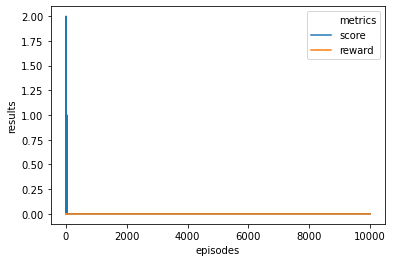

Run time: 79.7865469455719 seconds
Max. Score: 2
Mean Last Scores: 0.0


In [8]:
N0 = 1
gamma = 10

# define agent
monteCarloAgent = MonteCarloAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=default_reward, episodes=10000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))